<h1 id="tocheading">Проект: Исследование оттока клиентов фитнес-центра</h1>
<div id="toc"></div>

## Цель проекта
Проанализировать данные электронных анкет пользователей фитнес-центра и определить основные причины оттока клинетов

### План работы:
[ 1. Импорт нужных библиотек и датасетов..](#step1)

[ 2. Исследовательский анализ данных (EDA) ](#step2)


[ 3. Модель прогнозирования оттока пользователей ](#step3)


[ 4. Кластеризация пользователей](#step4)


[ 5. Общий вывод и рекомендации по работе с клиентами](#step5)

## <a id="step1">1. Импорт нужных библиотек и датасетов</a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = 50


pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) 

In [3]:
data = pd.read_csv('gym_churn.csv')

## <a id="step2">2. Исследовательский анализ данных </a>

In [4]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


При выделений средних значений характеристик пользователей можем заметить:
- Среди посетителей количество мужчин и женщин практически равно, мужчин 51% а женщин 49%
- Большинство клинетов выбирают зал поблизости работы или места проживания (в среднем 85%)
- Почти половина (49%) пользователей является сотрудниками компаний-партнеров клуба
- 31% пользователей использовали пришли в клуб в рамках кампании "приведи друга"
- 90% клиентов предоставили номер телефона при регистрации
- В среднем длительность контракта членов клуба составляет 4.68 месяца
- Средний возраст посетителей составляет примерно 29 лет, хотя стандартное отклонение невелико и 75% значений возраста посетителей клуба не старше 31 года
- На момент получений информации среднее время до конца контракта у пользователей составляло чуть более 4 месяцев
- В среднем за неделю пользователи посещают клуб чуть менее двух раз (если считать с начала пользования клуба)
- Доля оттока клиентов составляет в среднем 27% 

In [5]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Как можем заметить, отсутствуют пропущенные значения и все характеристии в таблице имеют по 4000 значений. Все типы данных соответствуют характеристикам, которые они отображают.

In [7]:
# приведем названия колонок к нижнему регистру
data.columns = data.columns.str.lower()

In [8]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


In [9]:
cols = data.columns

In [10]:
left = data.query('churn == 1')

In [11]:
stayed = data.query ('churn == 0')

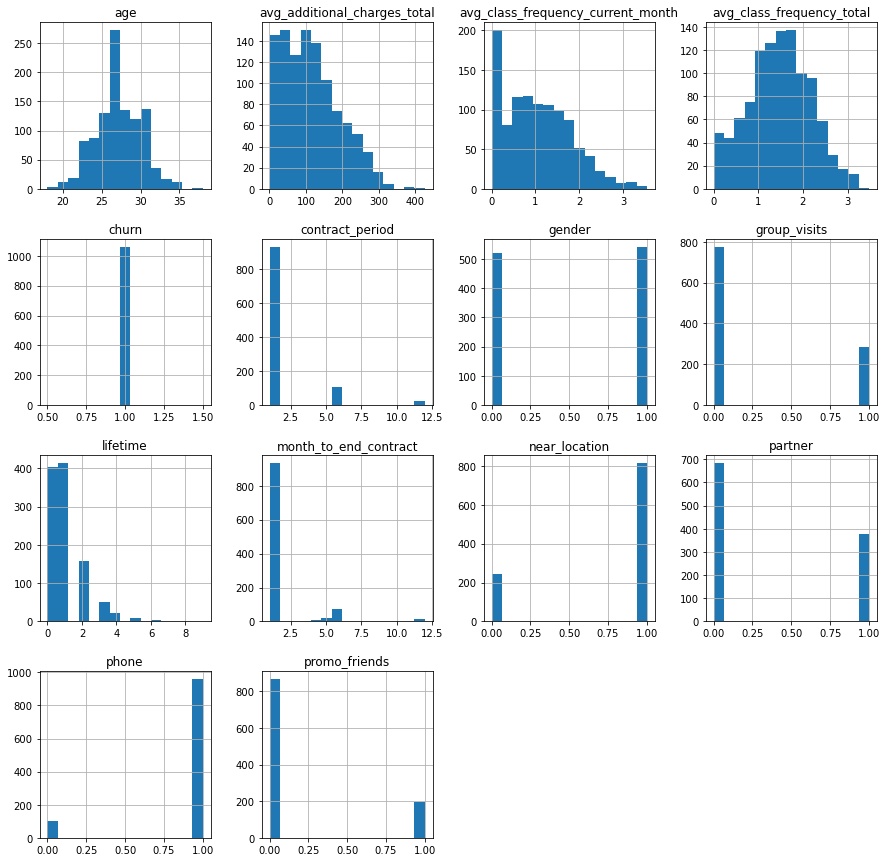

In [12]:
left.hist(figsize = (15,15), bins = 15)
plt.show()

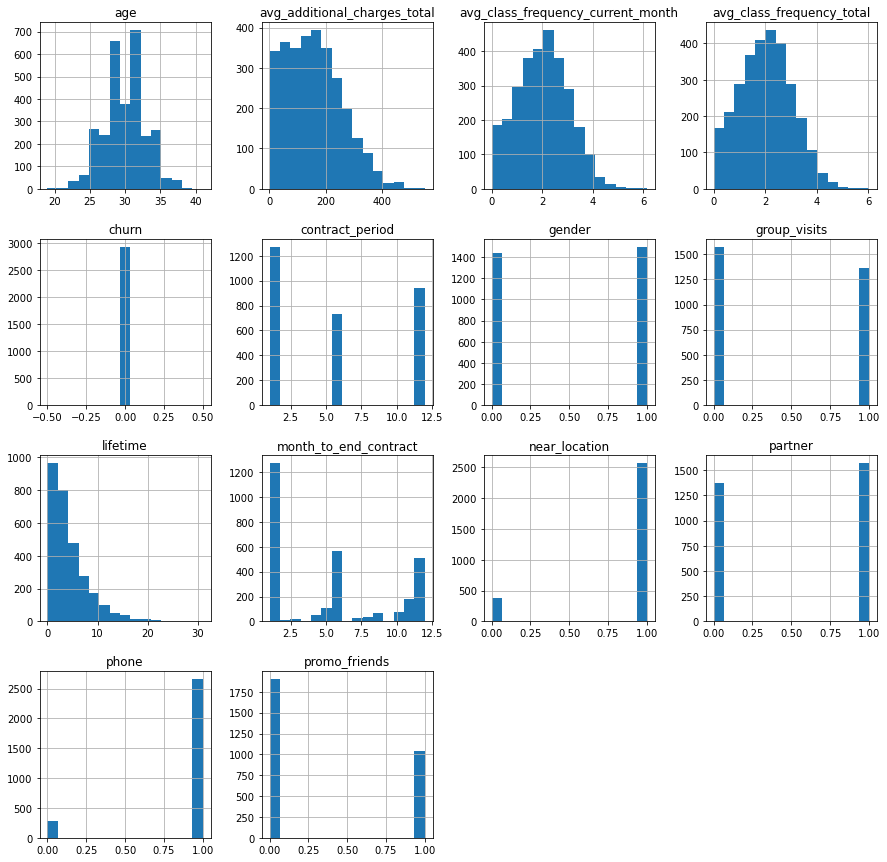

In [13]:
stayed.hist(figsize = (15,15), bins = 15)
plt.show()

1. У тех, кто остался возраст чуть больше смещен в сторону больших значений, они тратят больше "отвалившихся" пользователей дополнительных платежей (значения обрываются на 400, а у первых на 300).
2. У отвалившихся пользователей короче среднее время пользования сервисом за последний месяц и за все время в целом, что говорит о том, что если уже пользователей серьезно занялся улучшением своего физического состояния и регулярно ходит в клуб, то есть гораздо меньше вероятность того, что он перестанет ходить. Это подтверждается гороздо более частыми оттоком клиентов, которых заключили короткий контракт(1-2 месяца).
3. Средний жизненный цикл использования сервиса у бросивших клуб значительно короче, чем у тех, кто остался. 
4. Бросившие клуб гораздо реже принадлежали к партнерским организациям и пришли по промо-акции "приведи друга".
5. У тех кто остался и бросил практически отсутствует гендерная разница и наличие/отсутствие телефона.

In [14]:
matrix = data.corr()

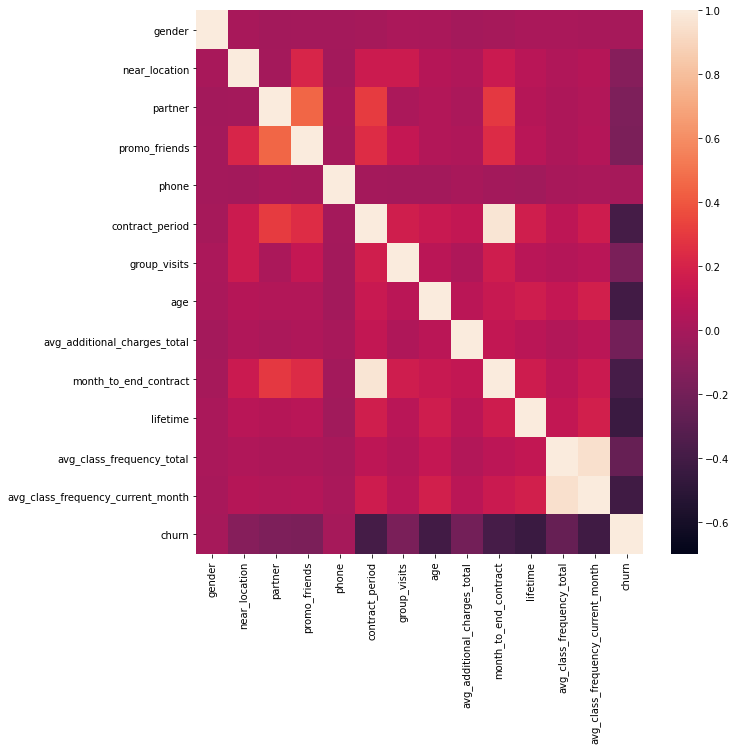

In [15]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(matrix, vmin=-0.7, vmax=1)
plt.show()

По матрице можем заметить, что наибольшая корреляция есть между оттоком пользователей и такими переменными как длительность контракта, возраст, длительность использования сервиса и средняя частота посещений клуба за последний месяц. 

## <a id="step3">3. Модель прогнозирования оттока пользователей.</a>

In [16]:
# выделим целевой признак как Х и характеристики пользователей как y
y = data['churn']
X = data.drop('churn', axis = 1)

Стандартизируем значения всех харатеристик, которые измеряются в своих единицах(например, среднего возраста и дополнительных плат), т.к они измеряются в разных единицах, у них достаточно разные средние и стандартные отклонения. Таким образом мы стандартизируем эти данные и облегчим последующий анализ и проверку моделей.

In [17]:
# задействуем нормализатор для стандартизации данных
scaler = StandardScaler()
# обучим нормализатор и преобразуем данные, удалив столбец с данными об оттоке, т.к они нам не нужны
X = scaler.fit_transform(X)

In [18]:
# разобьем выборки на обучающую и валидационную
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify = y)

In [19]:
# обозначим модель "случайного леса" 
model = RandomForestClassifier (random_state=0) 

In [20]:
# обучим модель
model.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [21]:
# сделаем прогноз для валидационной выборке при помощи получившейся из обучающей выборки модели
predictions = model.predict(X_test)

In [22]:
acc = accuracy_score(y_test, predictions)

In [23]:
precision = precision_score(y_test, predictions)

In [24]:
recall = recall_score(y_test, predictions)

In [25]:
model_lr = LogisticRegression(random_state = 0)

In [26]:
model_lr.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [27]:
predictions_lr = model_lr.predict(X_test)

In [28]:
acc_lr = accuracy_score(y_test, predictions_lr)

In [29]:
precision_lr=precision_score(y_test, predictions_lr)

In [30]:
recall_lr = recall_score(y_test,predictions_lr)

In [31]:
print('Метрики модели Random Forest')
print('Random Forest accuracy:', acc)
print('Random Forest precision:', precision)
print('Random Forest recall:', recall)

Метрики модели Random Forest
Random Forest accuracy: 0.9225
Random Forest precision: 0.875
Random Forest recall: 0.8254716981132075


In [32]:
print('Метрики модели Logistic Regression')
print('Linear regression accuracy:', acc_lr)
print('Linear regression precision:', precision_lr)
print('Linear regression recall:', recall_lr)

Метрики модели Logistic Regression
Linear regression accuracy: 0.935
Linear regression precision: 0.8960396039603961
Linear regression recall: 0.8537735849056604


Можем заключить, что на основании метрик, измеряющих работу обеих моделей на валидационной выборке, модель "случайного леса" показала себя немного слабее, чем логистическая регрессия. 

## <a id="step4">4. Кластеризация пользователей.</a>

#### Выделение кластеров при помощи метода linked и дендограммы

In [33]:
# задействуем нормализатор для стандартизации данных
scaler = StandardScaler()

In [34]:
# обучим нормализатор и преобразуем данные, удалив столбец с данными об оттоке, т.к они нам не нужны
x_sc = scaler.fit_transform(data.drop(columns = ['churn']))

In [35]:
# используем метод lined для создания таблицы 'связок' между объектами
linked = linkage(x_sc, method = 'ward')

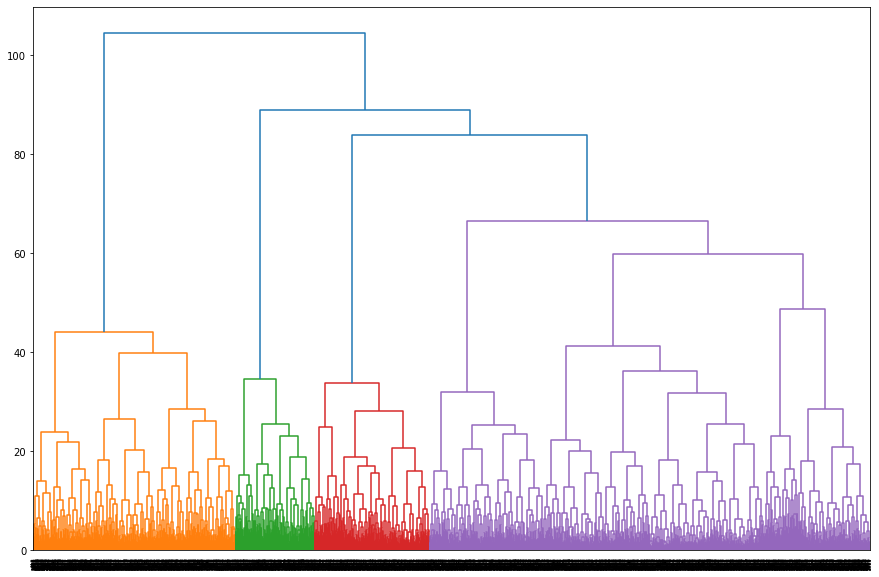

In [36]:
# нарисуем дендограмму, чтобы увидеть сколько кластеров можно выделить
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Можем выделить четыре кластера клиентов на основе похожести изменчивости их признаков.

#### Кластеризация на основе алгоритма K-means

In [37]:
 # задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state = 0)

In [38]:
# прогнозируем метки кластеров (от 0 до 4, т.к всего 5) для наблюдения 
labels = km.fit_predict(x_sc)

In [39]:
# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

In [40]:
# посмотрим на средние значения в разрезе по кластерам
data.groupby('cluster_km',as_index=False).mean()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
1,1,0.48,0.81,0.00,0.09,1.00,1.87,0.33,28.15,131.37,1.79,2.35,1.33,1.09,0.55
2,2,0.56,0.86,0.34,0.20,1.00,2.73,0.45,30.20,164.58,2.52,5.01,2.93,2.93,0.05
3,3,0.51,0.75,1.00,0.45,1.00,2.55,0.30,28.50,129.81,2.37,2.83,1.36,1.18,0.40
4,4,0.50,0.94,0.75,0.54,1.00,11.35,0.56,29.99,164.56,10.38,4.82,2.03,2.02,0.02


1. В кластере 2 наибольший отток клиентов(55%), в то время как в кластере 4 таких только 2%, а в кластере 2 - 5%. 
2. Также у клиентов, склонных к уходу, меньше длительность посещения клуба и срок до конца контракта(1.79 месяцев VS 10.38 месяцев у тех, кто склонен продолжать пользоваться услугами сервиса). Т.е ушедшие пользователи изначально были более склонны к заключению краткосрочных контрактов и таким образом "путь к отступлению" нёс для них меньшие издержки. 
3. В кластере с наибольшим оттоком клиентов наименьшее значение (0) сотрудников партнерских организаций и совсем немного пришедших по промо-коду акции "приведи друга". Это говорит о том, что это важные факторы потенциального оттока клиентов. Т.е те, кто приходил из партнёрских организаций и получал определенную скидку оставалиьс более лояльными клубу благодаря меньшей цене или своим предпочтениям, которые формировались принадлежностью партнерскими организациями.
3. Также среди кластеров 1 и 3 высоким уровнем оттока (0.55 и 0.40 соответственно) мы можем заметить низкие значения в общем количестве посещений и посещений за последний месяц. Это говорит о том, что если пользователь занимается не регулярно, то у него гораздо больше соблазна прекратить использовать сервис. 
4. Период контракта является важным фактором продолжения использования услуг сервиса. Как можем заметить у клиентов кластера 4 этот показатель составляет 10.38 и гораздо выше, чем у остальных кластеров. Этот же пункт подтверждается средним временем до окончания контракта у пользователей кластера 4 и кластера 2 (соответственно 4.82 и 5.01), что значительно выше, чем у остальных кластеров. 

Выделим 5 датафреймов, каждый из которыз отфильтрован по кластеру

In [41]:
cluster_0 = data[data['cluster_km'] == 0]

In [42]:
cluster_1 = data[data['cluster_km'] == 1]

In [43]:
cluster_2 = data[data['cluster_km'] == 2]

In [44]:
cluster_3 = data[data['cluster_km'] == 3]

In [45]:
cluster_4 = data[data['cluster_km'] == 4]

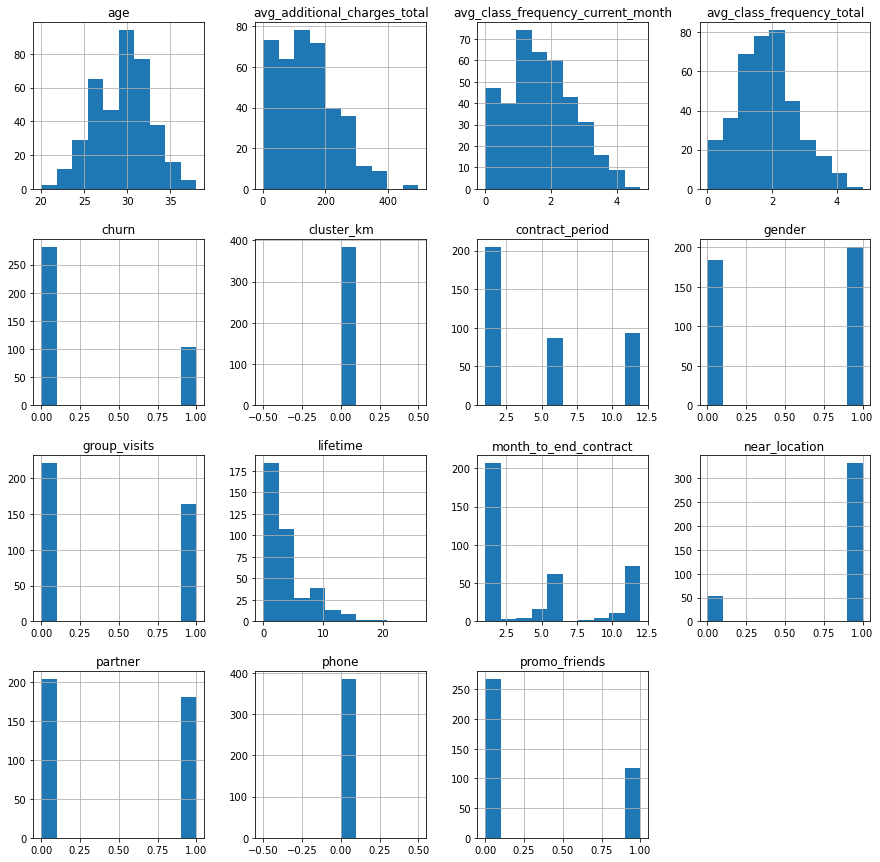

In [46]:
cluster_0.hist(figsize = (15,15))
plt.show()

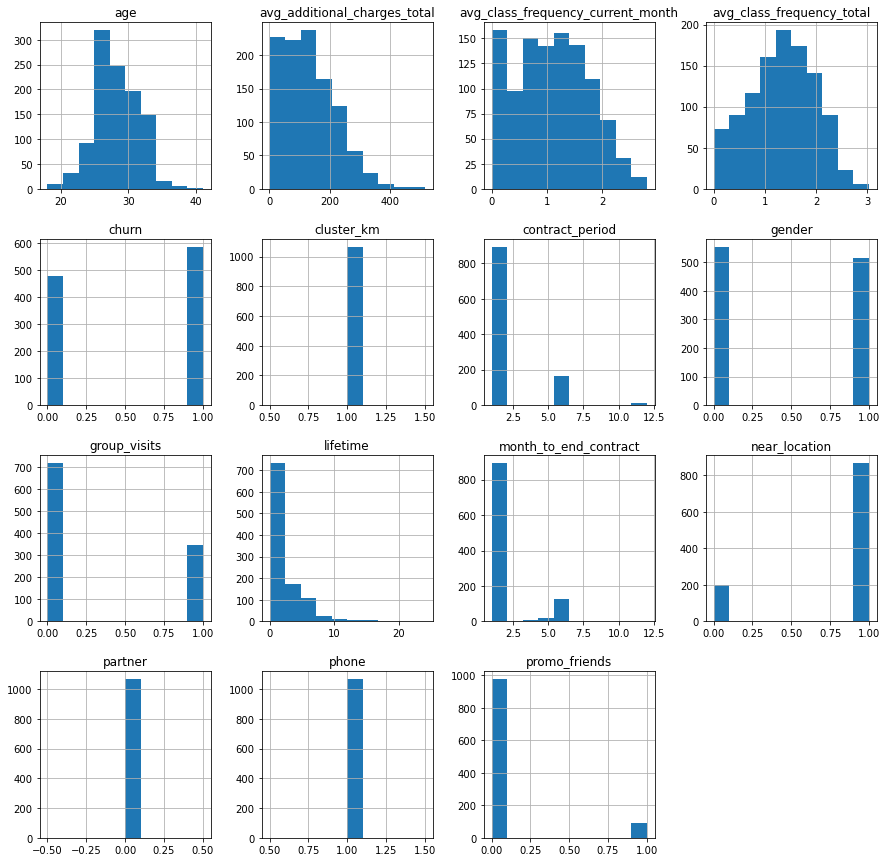

In [47]:
cluster_1.hist(figsize = (15,15))
plt.show()

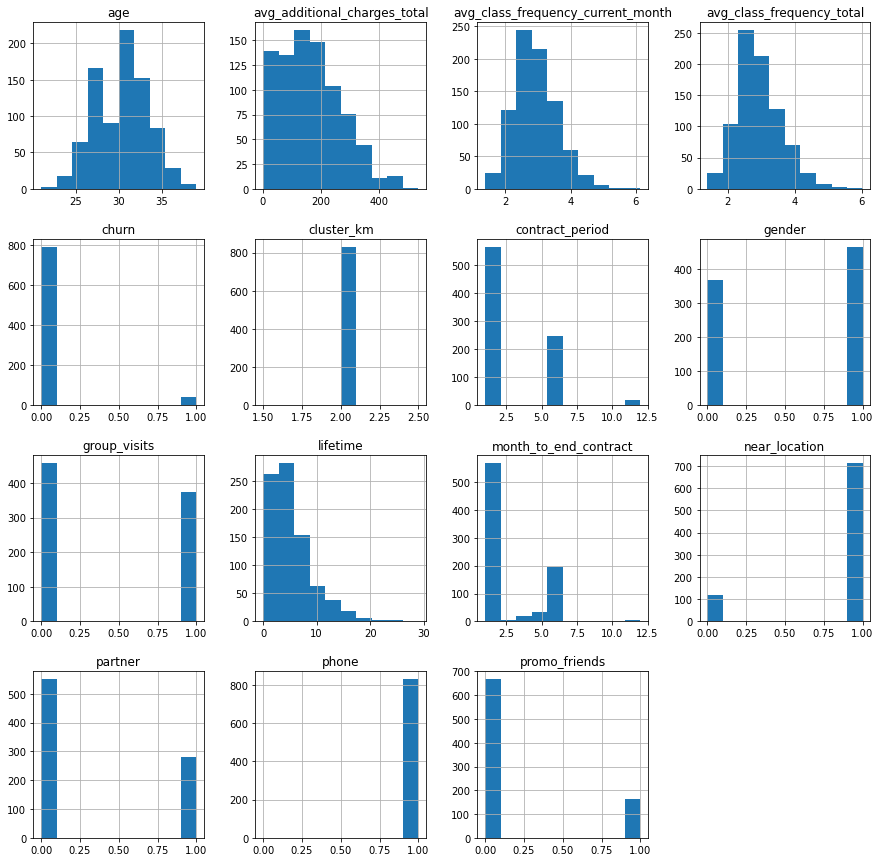

In [48]:
cluster_2.hist(figsize = (15,15))
plt.show()

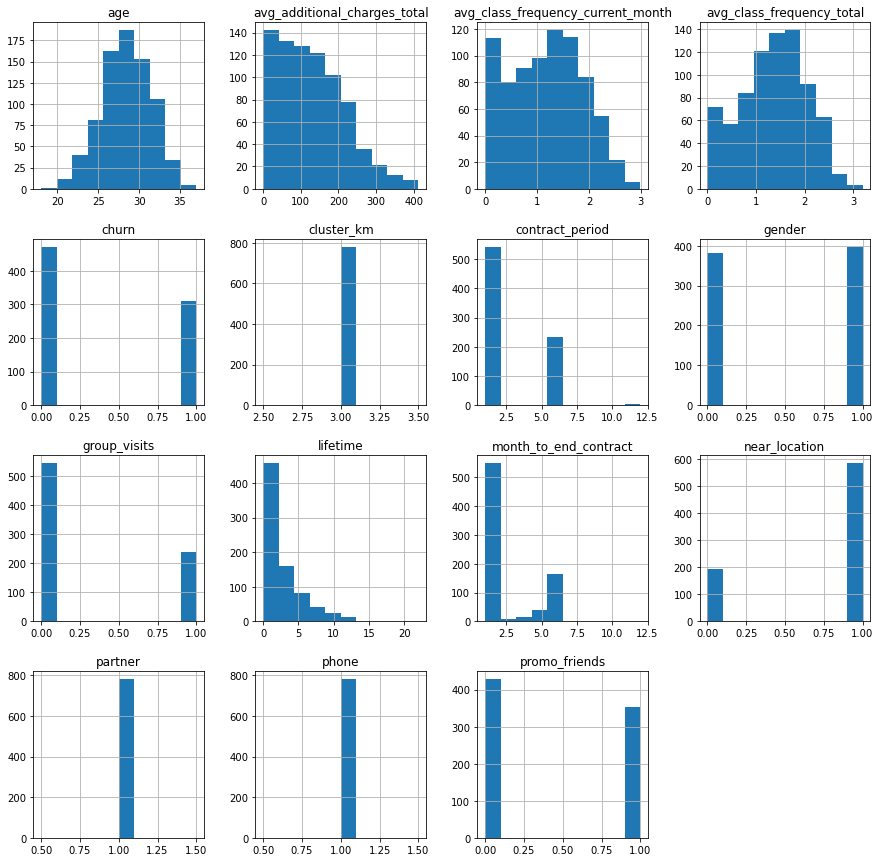

In [49]:
cluster_3.hist(figsize = (15,15))
plt.show()

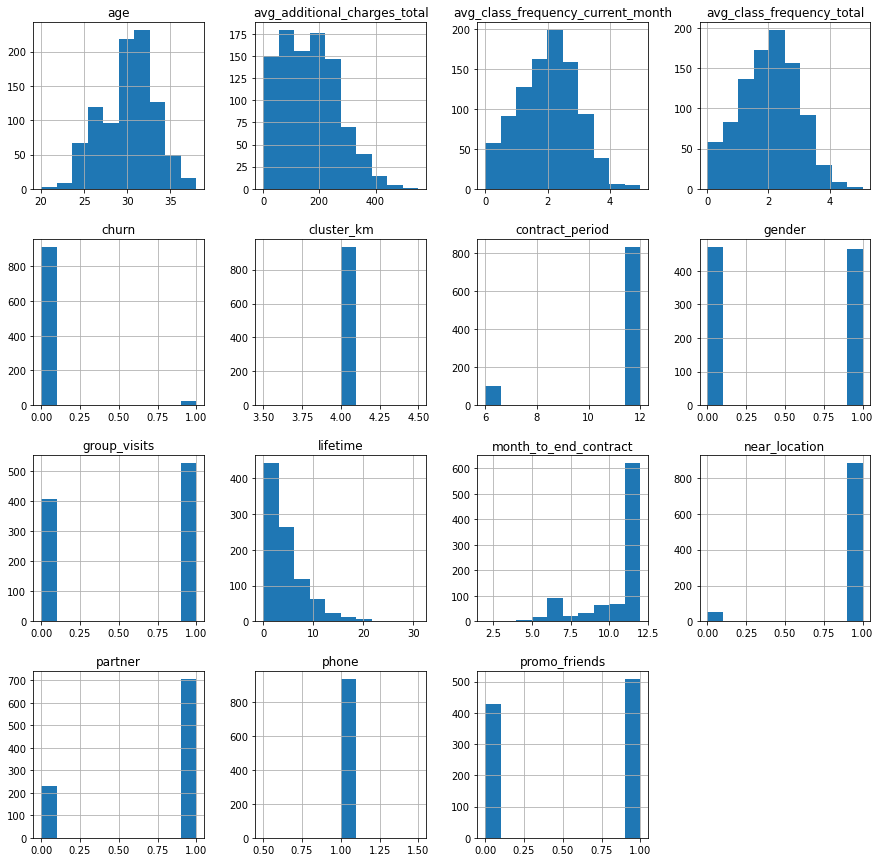

In [50]:
cluster_4.hist(figsize = (15,15))
plt.show()

1. Можем заметить, что по распределениям четвертый кластер отличается от остальных. В некоторых характеристиках незначительно, а в некоторых довольно серьезно.
2. Например, частота занятий в месяц и за весь период немного больше сдвинута в сторону бОльших значений. 
3. А вот длительность контракта и время до конца окончания контракта очень розница по сравнению с другими кластерами, т.к очень сильно смещена в сторону больших значений. 

In [51]:
# доля оттока в разрезе на разные кластеры 
data.groupby('cluster_km').agg({'churn':'mean'}).reset_index()

,cluster_km,churn
0,0,0.27
1,1,0.55
2,2,0.05
3,3,0.40
4,4,0.02


1. Кластер 4 с 2% оттока и кластер 2 с 5% оттока значительно отличаются от остальных кластеров, уровень оттока в которых колеблется от 27% до 55%.
2. Кластер 1 наиболее склонен к оттоку(55%), а кластер 4 наименее склонен к оттоку(2%).

## <a id="step5">5. Выводы и рекомендации.</a>

1. Выводы

    - Модель "случайного леса" продемонстрировала себя немного слабее, чем модель логистической регрессии при прогнозировании оттока пользователей.
    - При использовании кластеризации на основе модели KMeans выделился наиболее перспективный кластер 4, в котором отток клиентов составляет всего 2%, а также класте 2 с 5% оттока клиентов, что тоже очень неплохо. 
    
2. Рекомендации:

    - На основе кластеризации можем заключить, что длительность заключенного контракта и длительность времени до конца контракта играют важную роль в предотвращении оттока пользователей. Соответственно, хорошей маркетинговой стратегией может являтся стимуляция заключения новыми клиентами фитнес-центра долгосрочных контрактов.
    - Практика распространение прокода друзьями и сотрудничество с компаниями-партнерами подтвердила свое позитивное влияние. Поэтому можно посоветовать продолжение или расширения использования этих практик и маркетинговых стратегий в будущем для привлечения и удержания клиентов.